In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating environment at `~/Documents/optimal_control_julia/lec_16/Project.toml`
    Updating registry at `~/.julia/registries/General`
    Updating `~/Documents/optimal_control_julia/lec_16/Project.toml`
  [5ae59095] + Colors v0.12.10
  [150eb455] + CoordinateTransformations v0.6.3
  [f6369f11] + ForwardDiff v0.10.36
  [5c1252a2] + GeometryBasics v0.4.10
  [b6b21f68] + Ipopt v1.6.2
  [b8f27783] + MathOptInterface v1.27.1
  [283c5d60] + MeshCat v0.16.1
  [91a5bcdd] + Plots v1.40.3
  [d330b81b] + PyPlot v2.11.2
  [6038ab10] + Rotations v1.7.0
  [90137ffa] + StaticArrays v1.9.3
    Updating `~/Documents/optimal_control_julia/lec_16/Manifest.toml`
  [79e6a3ab] + Adapt v4.0.4
  [6e4b80f9] + BenchmarkTools v1.5.0
  [d1d4a3ce] + BitFlags v0.1.8
  [7057c7e9] + Cassette v0.3.13
  [d360d2e6] + ChainRulesCore v1.23.0
  [9e997f8a] + ChangesOfVariables v0.1.8
  [523fee87] + CodecBzip2 v0.8.2
  [944b1d66] + CodecZlib v0.7.4
  [35d6a980] + ColorSchemes v3.24.0
  [3da002f7] + ColorTypes v0.11.5
  

  [214eeab7] + fzf_jll v0.43.0+0
  [1a1c6b14] + gperf_jll v3.1.1+0
  [a4ae2306] + libaom_jll v3.4.0+0
  [0ac62f75] + libass_jll v0.15.1+0
  [2db6ffa8] + libevdev_jll v1.11.0+0
  [f638f0a6] + libfdk_aac_jll v2.0.2+0
  [36db933b] + libinput_jll v1.18.0+0
  [b53b4c65] + libpng_jll v1.6.43+1
  [f27f6e37] + libvorbis_jll v1.3.7+1
  [009596ad] + mtdev_jll v1.1.6+0
  [1270edf5] + x264_jll v2021.5.5+0
  [dfaa095f] + x265_jll v3.5.0+0
  [d8fb68d0] + xkbcommon_jll v1.4.1+1
  [0dad84c5] + ArgTools
  [56f22d72] + Artifacts
  [2a0f44e3] + Base64
  [ade2ca70] + Dates
  [8bb1440f] + DelimitedFiles
  [f43a241f] + Downloads
  [b77e0a4c] + InteractiveUtils
  [b27032c2] + LibCURL
  [76f85450] + LibGit2
  [8f399da3] + Libdl
  [37e2e46d] + LinearAlgebra
  [56ddb016] + Logging
  [d6f4376e] + Markdown
  [a63ad114] + Mmap
  [ca575930] + NetworkOptions
  [44cfe95a] + Pkg
  [de0858da] + Printf
  [9abbd945] + Profile
  [3fa0cd96] + REPL
  [9a3f8284] + Random
  [ea8e919c] + SHA
  [9e88b42a] + Serialization
  [646

In [2]:
using LinearAlgebra
using PyPlot
using ForwardDiff
using Ipopt
using MathOptInterface
const MOI = MathOptInterface;

[ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
[ Info: Precompiling ForwardDiff [f6369f11-7733-5829-9624-2563aa707210]
[ Info: Precompiling Ipopt [b6b21f68-93f8-5de0-b562-5493be1d77c9]


In [3]:
Nx = 8     # number of state
Nu = 2     # number of controls
Tfinal = 4.4 # final time
h = 0.1 #10 hz
Nm = 5 #number of steps in each mode
Nt = Int(ceil(Tfinal/h)+1)   # number of time steps
Nmodes = Int(ceil(Nt/Nm))

9

In [4]:
thist = Array(range(0,h*(Nt-1), step=h));

n_nlp = Nx*Nt + Nu*(Nt-1) # number of decision variables
c_init_inds = 1:Nx
c_term_inds = (c_init_inds[end]+1):(c_init_inds[end]+Nx)
c_dyn_inds = (c_term_inds[end]+1):(c_term_inds[end]+Nx*(Nt-1))
c_stance_inds = (c_dyn_inds[end]+1):(c_dyn_inds[end]+Int(ceil(Nmodes/2)*Nm))
c_length_inds = (c_stance_inds[end]+1):(c_stance_inds[end]+Nt)
m_nlp = c_length_inds[end]

438

In [5]:
#Hopper Dynamics
g = 9.81
m1 = 5.0 #body mass
m2 = 1.0 #foot mass
ℓ_min = 0.5 #minimum length
ℓ_max = 1.5 #maximum length

function flight_dynamics(x,u)
    M = Diagonal([m1 m1 m2 m2])
    
    r1 = x[1:2]
    r2 = x[3:4]
    v = x[5:8]
    
    ℓ1 = (r1[1]-r2[1])/norm(r1-r2)
    ℓ2 = (r1[2]-r2[2])/norm(r1-r2)
    B = [ℓ1  ℓ2;
         ℓ2 -ℓ1;
        -ℓ1 -ℓ2;
        -ℓ2  ℓ1]
    
    v̇ = [0; -g; 0; -g] + M\(B*u)
    
    ẋ = [v; v̇]
end

function stance_dynamics(x,u)
    m1 = 5.0 #body mass
    m2 = 1.0 #foot mass
    M = Diagonal([m1 m1 m2 m2])
    g = 9.81
    
    r1 = x[1:2]
    r2 = x[3:4]
    v = x[5:8]
    
    ℓ1 = (r1[1]-r2[1])/norm(r1-r2)
    ℓ2 = (r1[2]-r2[2])/norm(r1-r2)
    B = [ℓ1  ℓ2;
         ℓ2 -ℓ1;
         0   0;
         0   0]
    
    v̇ = [0; -g; 0; 0] + M\(B*u)
    
    ẋ = [v; v̇]
end

function flight_dynamics_rk4(x,u)
    #RK4 integration with zero-order hold on u
    f1 = flight_dynamics(x, u)
    f2 = flight_dynamics(x + 0.5*h*f1, u)
    f3 = flight_dynamics(x + 0.5*h*f2, u)
    f4 = flight_dynamics(x + h*f3, u)
    return x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
end

function stance_dynamics_rk4(x,u)
    #RK4 integration with zero-order hold on u
    f1 = stance_dynamics(x, u)
    f2 = stance_dynamics(x + 0.5*h*f1, u)
    f3 = stance_dynamics(x + 0.5*h*f2, u)
    f4 = stance_dynamics(x + h*f3, u)
    return x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
end

function jump_map(x)
    #Assume the foot experiences inelastic collisions
    xn = [x[1:6]; 0.0; 0.0]
    return xn
end

jump_map (generic function with 1 method)

In [6]:
# Cost weights
Q = Diagonal([1.0*ones(4); 1.0*ones(4)]);
R = 0.001;
Qn = Q

8×8 Diagonal{Float64, Vector{Float64}}:
 1.0   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅   1.0   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅   1.0   ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅   1.0   ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅   1.0   ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅   1.0   ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   1.0   ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   1.0

In [7]:
function stage_cost(x,u,k)
    return 0.5*((x-xref[:,k])'*Q*(x-xref[:,k])) + 0.5*(u-uref)'*R*(u-uref)
end
function terminal_cost(x)
    return 0.5*((x-xref[:,end])'*Qn*(x-xref[:,end]))
end

terminal_cost (generic function with 1 method)

In [8]:
function cost(ztraj)
    z = reshape(ztraj[1:(end-Nx)],Nx+Nu,Nt-1)
    xtraj = [z[1:Nx,:] ztraj[end-(Nx-1):end]]
    utraj = z[(Nx+1):(Nx+Nu),:]
    J = 0.0
    for k = 1:(Nt-1)
        J += stage_cost(xtraj[:,k],utraj[:,k],k)
    end
    J += terminal_cost(xtraj[:,end])
    return J
end

cost (generic function with 1 method)

In [9]:
#Reference Trajectory
uref = [m1*g; 0.0]
xref = zeros(Nx,Nt)
xref[1,:] .= LinRange(-1.0,1.0,Nt)
xref[2,:] .= 1.0 .+ 0.5.*sin.(2*pi/10.0*(0:(Nt-1)));
xref[3,:] .= LinRange(-1.0,1.0,Nt)
xref[5,2:end-1] .= (2.0/Tfinal)*ones(Nt-2)
xref[7,2:end-1] .= (2.0/Tfinal)*ones(Nt-2);

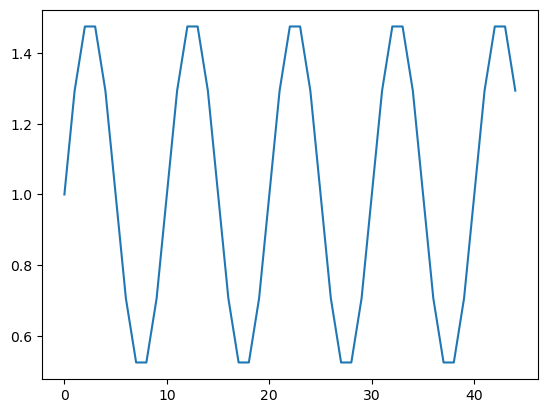

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000068E2BA90>

In [10]:
plot(xref[2,:])

In [11]:
function dynamics_constraint!(c,ztraj)
    d = reshape(view(c,c_dyn_inds),Nx,Nt-1)
    z = reshape(ztraj[1:(end-Nx)],Nx+Nu,Nt-1)
    xtraj = [z[1:Nx,:] ztraj[end-(Nx-1):end]]
    utraj = z[(Nx+1):(Nx+Nu),:]
    for k = 1:(Nmodes-1)
        if mod(k,2) == 1
            for j = 1:Nm
                s = (k-1)*Nm + j
                d[:,s] = stance_dynamics_rk4(xtraj[:,s],utraj[:,s]) - xtraj[:,s+1]
            end
        else
            for j = 1:(Nm-1)
                s = (k-1)*Nm + j
                d[:,s] = flight_dynamics_rk4(xtraj[:,s],utraj[:,s]) - xtraj[:,s+1]
            end
            s = k*Nm
            d[:,s] = jump_map(flight_dynamics_rk4(xtraj[:,s],utraj[:,s])) - xtraj[:,s+1]
        end
    end

    
    if mod(Nmodes,2) == 1
        for j = 1:(Nm-1)
            s = (Nmodes-1)*Nm + j
            d[:,s] = stance_dynamics_rk4(xtraj[:,s],utraj[:,s]) - xtraj[:,s+1]
        end
    else
        for j = 1:(Nm-1)
            s = (Nmodes-1)*Nm + j
            d[:,s] = flight_dynamics_rk4(xtraj[:,s],utraj[:,s]) - xtraj[:,s+1]
        end
    end
    
    return nothing
end

dynamics_constraint! (generic function with 1 method)

In [12]:
function stance_constraint!(c,ztraj)
    d = view(c,c_stance_inds)
    z = reshape(ztraj[1:(end-Nx)],Nx+Nu,Nt-1)
    xtraj = [z[1:Nx,:] ztraj[(end-(Nx-1)):end]]
    t = 1
    for k = 1:Nmodes
        if mod(k,2) == 1
            for j = 1:Nm
                s = (k-1)*Nm + j
                # y foot = 0
                d[t] = xtraj[4,s]
                t += 1
            end
        end
            
    end
    return nothing
end

stance_constraint! (generic function with 1 method)

In [13]:
function length_constraint!(c,ztraj)
    d = view(c,c_length_inds)
    z = reshape(ztraj[1:(end-Nx)],Nx+Nu,Nt-1)
    xtraj = [z[1:Nx,:] ztraj[(end-(Nx-1)):end]]
    for k = 1:Nt
        d[k] = norm(xtraj[1:2,k] - xtraj[3:4,k])
    end
end

length_constraint! (generic function with 1 method)

In [14]:
function con!(c,ztraj)
    c[c_init_inds] .= ztraj[1:Nx] - xref[:,1] #initial state constraint
    c[c_term_inds] .= ztraj[(end-(Nx-1)):end] - xref[:,end] #terminal state constraint
    @views dynamics_constraint!(c,ztraj)
    @views stance_constraint!(c,ztraj)
    @views length_constraint!(c,ztraj)
end

con! (generic function with 1 method)

In [15]:
struct ProblemMOI <: MOI.AbstractNLPEvaluator
    n_nlp::Int
    m_nlp::Int
    idx_ineq
    obj_grad::Bool
    con_jac::Bool
    sparsity_jac
    sparsity_hess
    primal_bounds
    constraint_bounds
    hessian_lagrangian::Bool
end

function ProblemMOI(n_nlp,m_nlp;
        idx_ineq=c_length_inds,
        obj_grad=true,
        con_jac=true,
        sparsity_jac=sparsity_jacobian(n_nlp,m_nlp),
        sparsity_hess=sparsity_hessian(n_nlp,m_nlp),
        primal_bounds=primal_bounds(n_nlp),
        constraint_bounds=constraint_bounds(m_nlp,idx_ineq=idx_ineq),
        hessian_lagrangian=false)

    ProblemMOI(n_nlp,m_nlp,
        idx_ineq,
        obj_grad,
        con_jac,
        sparsity_jac,
        sparsity_hess,
        primal_bounds,
        constraint_bounds,
        hessian_lagrangian)
end

function primal_bounds(n)
    x_l = -Inf*ones(n)
    x_u = Inf*ones(n)
    return x_l, x_u
end

function constraint_bounds(m; idx_ineq=(1:0))
    c_l = zeros(m)
    c_l[idx_ineq] .= ℓ_min

    c_u = zeros(m)
    c_u[idx_ineq] .= ℓ_max
    return c_l, c_u
end

function row_col!(row,col,r,c)
    for cc in c
        for rr in r
            push!(row,convert(Int,rr))
            push!(col,convert(Int,cc))
        end
    end
    return row, col
end

function sparsity_jacobian(n,m)

    row = []
    col = []

    r = 1:m
    c = 1:n

    row_col!(row,col,r,c)

    return collect(zip(row,col))
end

function sparsity_hessian(n,m)

    row = []
    col = []

    r = 1:m
    c = 1:n

    row_col!(row,col,r,c)

    return collect(zip(row,col))
end

function MOI.eval_objective(prob::MOI.AbstractNLPEvaluator, x)
    cost(x)
end

function MOI.eval_objective_gradient(prob::MOI.AbstractNLPEvaluator, grad_f, x)
    ForwardDiff.gradient!(grad_f,cost,x)
    return nothing
end

function MOI.eval_constraint(prob::MOI.AbstractNLPEvaluator,g,x)
    con!(g,x)
    return nothing
end

function MOI.eval_constraint_jacobian(prob::MOI.AbstractNLPEvaluator, jac, x)
    ForwardDiff.jacobian!(reshape(jac,prob.m_nlp,prob.n_nlp), con!, zeros(prob.m_nlp), x)
    return nothing
end

function MOI.features_available(prob::MOI.AbstractNLPEvaluator)
    return [:Grad, :Jac]
end

MOI.initialize(prob::MOI.AbstractNLPEvaluator, features) = nothing
MOI.jacobian_structure(prob::MOI.AbstractNLPEvaluator) = prob.sparsity_jac

function solve(x0,prob::MOI.AbstractNLPEvaluator;
        tol=1.0e-6,c_tol=1.0e-6,max_iter=10000)
    x_l, x_u = prob.primal_bounds
    c_l, c_u = prob.constraint_bounds

    nlp_bounds = MOI.NLPBoundsPair.(c_l,c_u)
    block_data = MOI.NLPBlockData(nlp_bounds,prob,true)

    solver = Ipopt.Optimizer()
    solver.options["max_iter"] = max_iter
    solver.options["tol"] = tol
    solver.options["constr_viol_tol"] = c_tol

    x = MOI.add_variables(solver,prob.n_nlp)

    for i = 1:prob.n_nlp
        MOI.add_constraint(solver, x[i], MOI.LessThan(x_u[i]))
        MOI.add_constraint(solver, x[i], MOI.GreaterThan(x_l[i]))
        MOI.set(solver, MOI.VariablePrimalStart(), x[i], x0[i])
    end

    # Solve the problem
    MOI.set(solver, MOI.NLPBlock(), block_data)
    MOI.set(solver, MOI.ObjectiveSense(), MOI.MIN_SENSE)
    MOI.optimize!(solver)

    # Get the solution
    res = MOI.get(solver, MOI.VariablePrimal(), x)

    return res
end

solve (generic function with 1 method)

In [16]:
#Guess
xguess = xref + 0.1*randn(Nx,Nt)
uguess = kron(ones(Nt-1)', uref) + 0.1*randn(Nu,Nt-1)
z0 = [reshape([xguess[:,1:(Nt-1)]; uguess],(Nx+Nu)*(Nt-1),1); xguess[:,end]];

In [17]:
prob = ProblemMOI(n_nlp,m_nlp)
z_sol = solve(z0,prob) # solve


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   176064
Number of nonzeros in inequality constraint Jacobian.:    20160
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      448
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      393
Total number of inequality co

448-element Vector{Float64}:
  -0.9999999999999999
   1.0000000000000002
  -1.0000000000000002
   3.0714368933261586e-18
   3.0508191005451203e-17
   1.803906150012275e-17
  -5.541529597236809e-17
  -1.0032665829844905e-16
  36.54384991981438
   9.528389959427082
  -0.9904132480280481
   0.9874784831917157
  -1.0000000000000002
   ⋮
   1.5141306774593405e-17
   9.09170014134357e-18
  27.715466503342284
 -11.611804943835923
   0.9999999999999999
   1.2938926261462371
   1.0
  -2.922442113516841e-18
   3.3852721579240153e-17
   2.5659372172792535e-17
   7.570653407842819e-18
   4.545851120501481e-18

In [18]:
z = reshape(z_sol[1:(end-Nx)],Nx+Nu,Nt-1)
xtraj = [z[1:Nx,:] z_sol[end-(Nx-1):end]]
utraj = z[(Nx+1):(Nx+Nu),:];

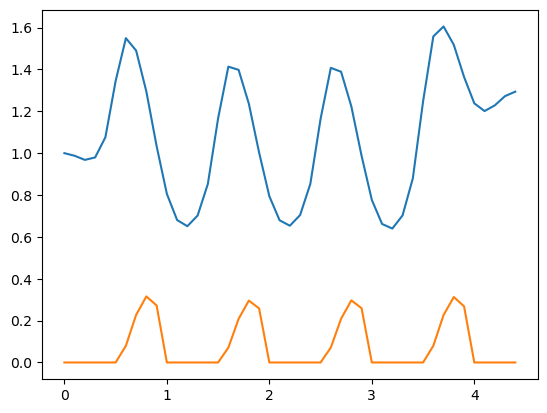

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000CC631E70>

In [19]:
plot(thist,xtraj[2,:])
plot(thist,xtraj[4,:])

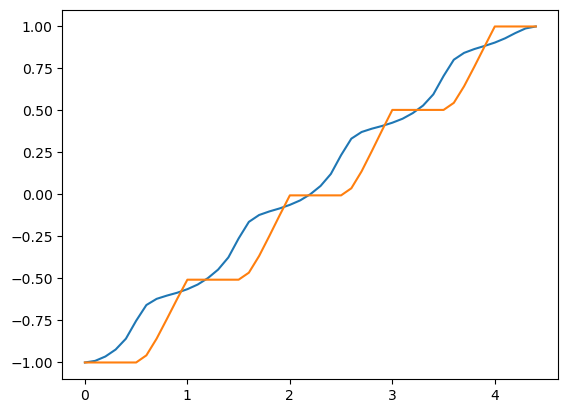

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000012A13F0>

In [20]:
plot(thist,xtraj[1,:])
plot(thist,xtraj[3,:])

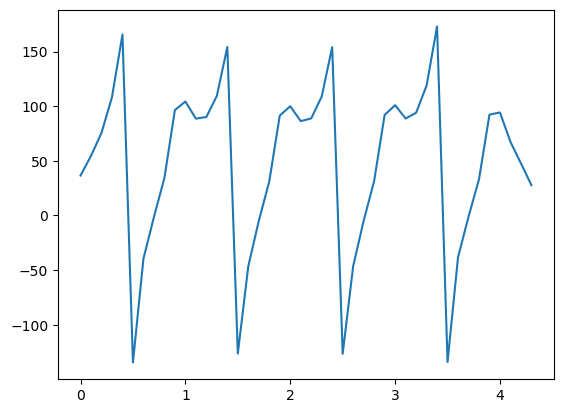

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000001307DC0>

In [21]:
plot(thist[1:end-1],utraj[1,:])

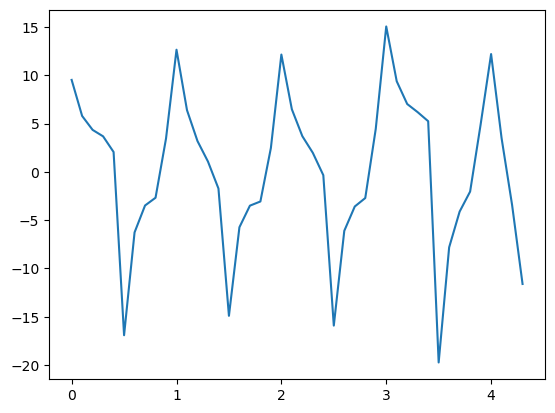

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000000000139D0F0>

In [22]:
plot(thist[1:end-1],utraj[2,:])

In [23]:
#Set up visualizer
using Colors
using CoordinateTransformations
using GeometryBasics
using MeshCat
using Rotations
using StaticArrays

# Kinematics
kinematics(q) = [q[3], q[4]]

# Visualization
function visualize!(vis, q, Δt)

    # body radius
    r_body = 0.2
	# foot radius
    r_foot = 0.1

	# leg width
    r_leg = 0.5 * r_foot

	# set background to white
	setvisible!(vis["/Background"], true)
    setprop!(vis["/Background"], "top_color", RGBA(1.0, 1.0, 1.0, 1.0))
    setprop!(vis["/Background"], "bottom_color", RGBA(1.0, 1.0, 1.0, 1.0))
    setvisible!(vis["/Axes"], false)

	# create body
    setobject!(vis["body"], Sphere(Point3f0(0),
        convert(Float32, r_body)),
        MeshPhongMaterial(color = RGBA(0, 1, 0, 1.0)))

	# create foot
    setobject!(vis["foot"], Sphere(Point3f0(0),
        convert(Float32, r_foot)),
        MeshPhongMaterial(color = RGBA(1.0, 165.0 / 255.0, 0, 1.0)))

# 	# create leg
    n_leg = 100
    for i = 1:n_leg
        setobject!(vis["leg$i"], Sphere(Point3f0(0),
            convert(Float32, r_leg)),
            MeshPhongMaterial(color = RGBA(0, 0, 0, 1.0)))
    end

    p_leg = [zeros(3) for i = 1:n_leg]

	# animation
    anim = MeshCat.Animation(convert(Int, floor(1.0 / Δt)))

    for t = 1:length(q)
        p_body = [q[t][1], 0.0, q[t][2]]
        p_foot = [kinematics(q[t])[1], 0.0, kinematics(q[t])[2]]

        dir = [q[t][3] - q[t][1]; q[t][4] - q[t][2]]
        dir = dir ./ norm(dir)
        r_range = range(0, stop = sqrt((q[t][1] - q[t][3])^2.0 + (q[t][2] - q[t][4])^2.0), length = n_leg)
        for i = 1:n_leg
            p_leg[i] = [q[t][1] + r_range[i] * dir[1], 0.0, q[t][2] + r_range[i] * dir[2]]
        end
        
        z_shift = [0.0; 0.0; r_foot]

        MeshCat.atframe(anim, t) do
            settransform!(vis["body"], Translation(p_body + z_shift))
            settransform!(vis["foot"], Translation(p_foot + z_shift))

            for i = 1:n_leg
                settransform!(vis["leg$i"], Translation(p_leg[i] + z_shift))
            end
        end
    end

    MeshCat.setanimation!(vis, anim)
end

vis = Visualizer()
render(vis)

[ Info: Precompiling MeshCat [283c5d60-a78f-5afe-a0af-af636b173e11]
[ Info: Listening on: 127.0.0.1:8700, thread id: 1
┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8700
[ Info: Server on 127.0.0.1:8700 closing
[ Info: MeshCat server closed.
[ Info: Listening on: 127.0.0.1:8700, thread id: 1
┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8700


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), Set{HTTP.WebSockets.WebSocket}(), ip"127.0.0.1", 8700, HTTP.Servers.Server{HTTP.Servers.Listener{Nothing, Sockets.TCPServer}}(HTTP.Servers.Listener{Nothing, Sockets.TCPServer}(Sockets.InetAddr{Sockets.IPv4}(ip"127.0.0.1", 8700), "127.0.0.1", "8700", nothing, Sockets.TCPServer(Base.Libc.WindowsRawSocket(0x0000000000001514) active)), nothing, Set{HTTP.Connections.Connection}(), Task (runnable) @0x000000007d893530, ReentrantLock(nothing, Base.GenericCondition{Base.Threads.SpinLock}(Base.InvasiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), 0))))

In [24]:
q = [SVector{4}(x[1:4]) for x in eachcol(xtraj)];
visualize!(vis, q, h)